# Tokyo Drift Team | Toyota Innovation Project

**Problem:**

The main focus of the TMMC Engineering project team is to find a reliable solution for using automation to peel off the stickers from the sticker roll and apply them over the body hole using vision integrated robotics. **However, TMMC are seeking help on how to inspect the quality of the sticker application.** 

**Requirements:**

An inspection method/system is required to: 


*  Confirm the presence of all 7 stickers applied by the robot 
*  Confirm the body holes are fully covered by the stickers. A perfectly positioned sticker has at least 3mm between the edge of the sticker and the edge of the hole to ensure proper coverage
*   Confirm that the stickers are flush with the surface (e.g. no wrinkles)
The total inspection time for all 7 stickers should not exceed 15 seconds 
For this challenge, you can ignore the time required to move the camera during inspection operations

**Connect Google Drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Relevant Libraries:**

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from IPython.display import display, Javascript, Image

from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import math

#Get Python and OpenCV Version

print('OpenCV-Python Lib Version:', cv2.__version__)
print('Python Version:',sys.version)

OpenCV-Python Lib Version: 4.7.0
Python Version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


Webcam image cature


In [ ]:

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

  try:
    filename = take_photo('photo.jpg')
    print('Saved to {}'.format(filename))
    
    # Show the image which was just taken.
    display(Image(filename))
    r
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

**Initializing I/O stream for pictures (change image file path and add more images as needed)**


DatatypeClass of Image: <class 'numpy.ndarray'>
Shape/Size of RGB Img: (720, 1280, 3)


Text(0.5, 1.0, 'RGB Image')

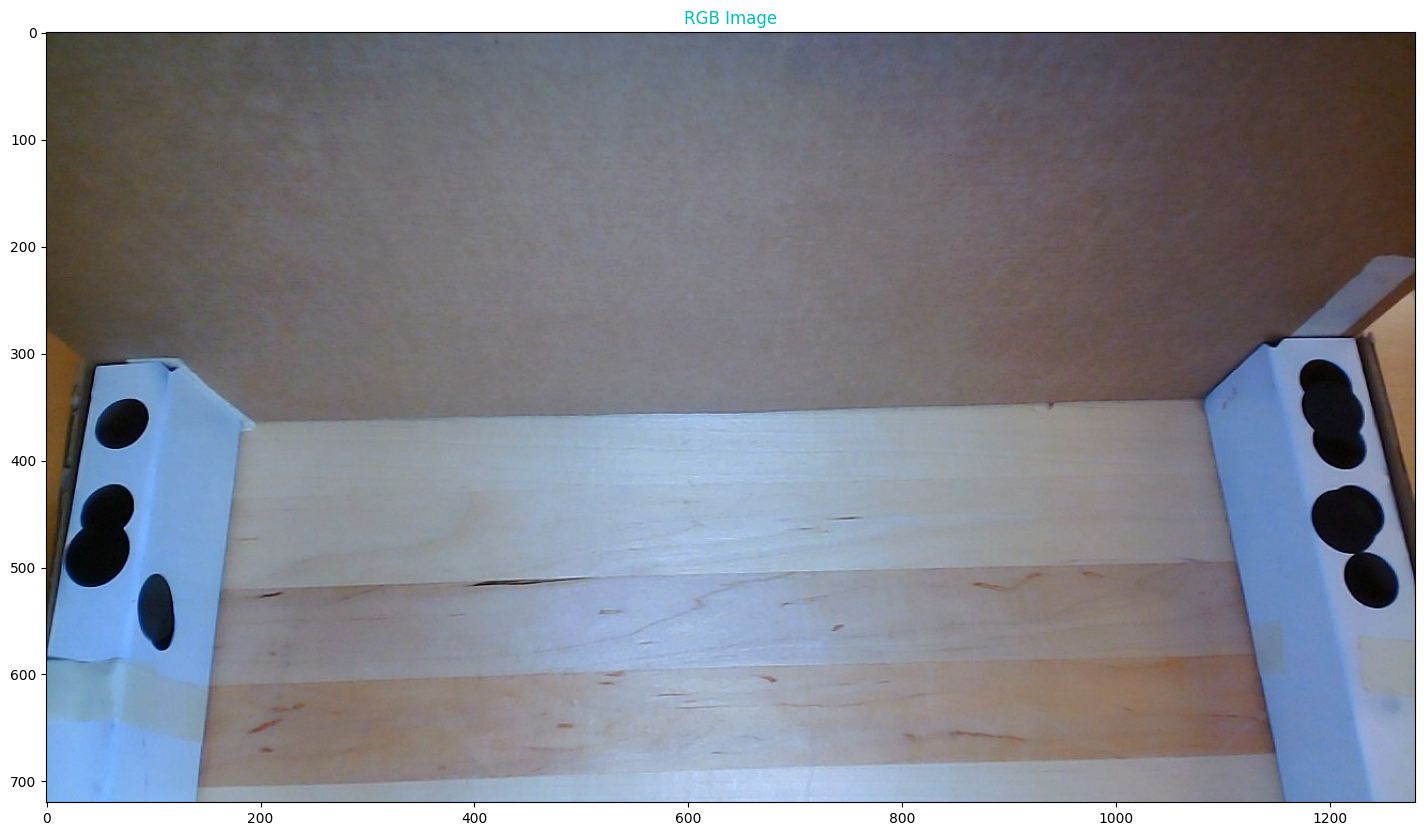

In [ ]:
Image_path = '/content/gdrive/MyDrive/Toyota Innovation Challenge Documents/Training Images/White/White_14.jpg'
MainImgBGR = cv2.imread(Image_path,cv2.IMREAD_UNCHANGED)
print('DatatypeClass of Image:',type(MainImgBGR))
print('Shape/Size of RGB Img:', MainImgBGR.shape)

plt.figure(figsize=(20,10))
#Note: matplotlib uses RGB format so had to convert BGR-to-RGB
plt.imshow(cv2.cvtColor(MainImgBGR,cv2.COLOR_BGR2RGB))
plt.title('RGB Image',color='c')

# Why use cv2.IMREAD_UNCHANGED with IMREAD?
# https://stackoverflow.com/a/18871394
# https://docs.opencv.org/3.4.3/d4/da8/group__imgcodecs.html#gga292d81be8d76901bff7988d18d2b42acae80c3e72393ec86b8ea1db4a2a228b5f

**Convert to Grayscale**

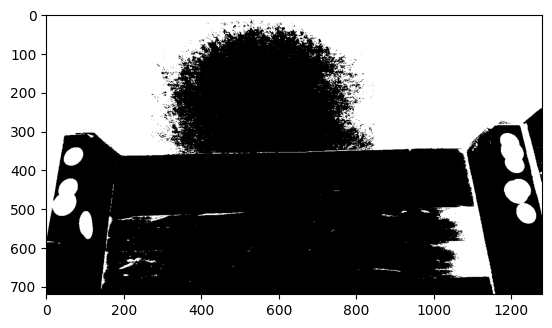

In [ ]:
#Convert to Gray
img_gry = cv2.cvtColor(MainImgBGR,cv2.COLOR_BGR2GRAY)

#Convert to Binary
# Method: Basic Thresholding
ret,img_bin = cv2.threshold(img_gry,127,255,cv2.THRESH_BINARY)
ret,img_bininv = cv2.threshold(img_gry,127,255,cv2.THRESH_BINARY_INV)

# Method: Adaptive Thresholding
img_adp_gusbin = cv2.adaptiveThreshold(img_gry,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,5)
img_adp_meanbin = cv2.adaptiveThreshold(img_gry,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,5)

# Method: Otsu's Thresholding
ret,img_Otsubin = cv2.threshold(img_gry,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(img_Otsubin,cmap='binary')

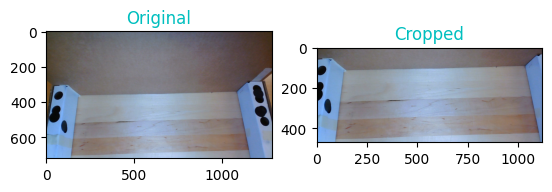

In [ ]:
img = cv2.imread(Image_path,cv2.IMREAD_UNCHANGED)

#Slicing using ROI
cropped = img[250:,50:1170].copy()
plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Original',color='c')
plt.subplot(122),plt.imshow(cv2.cvtColor(cropped,cv2.COLOR_BGR2RGB)),plt.title('Cropped',color='c')
 
MainImgBGR = cv2.GaussianBlur(MainImgBGR, (17, 17), 0)
cropped = cv2.GaussianBlur(cropped, (17, 17), 0)

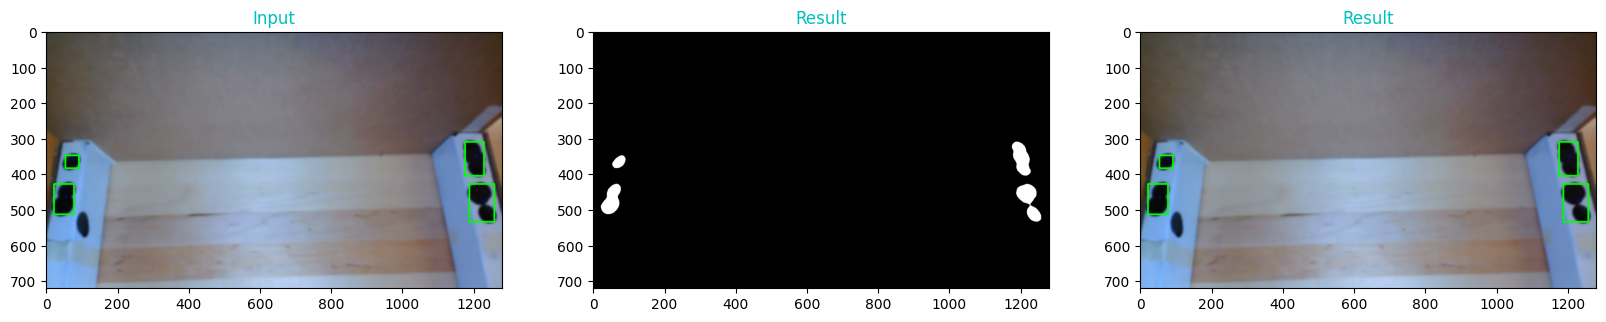

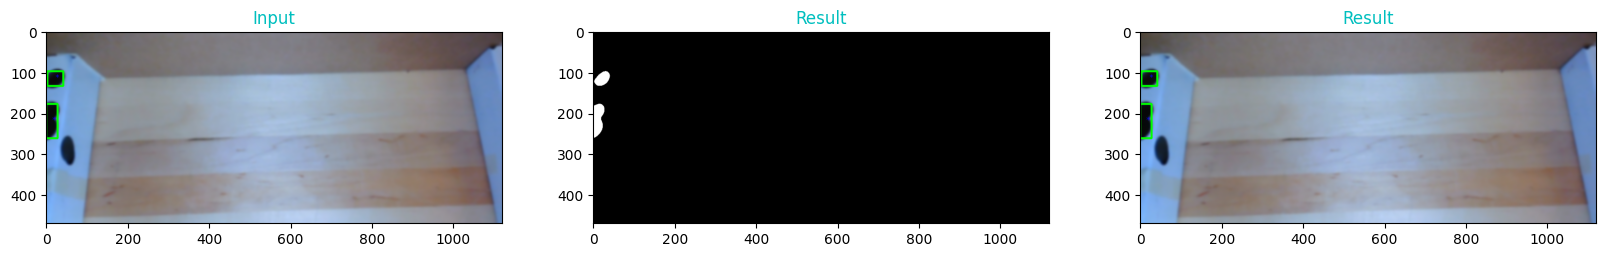

In [ ]:
#HSV Based
def detectColorObjectsfororiginal(path_to_img,find_color=None): 
    if isinstance(path_to_img, str):
        img = cv2.imread(path_to_img)
    else:
        img = path_to_img.copy()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    if find_color == 'black':
      BlackLower = np.array([0, 0, 0])
      BlackUpper = np.array([180, 255, 30])
      img_mask = cv2.inRange(img_hsv, BlackLower, BlackUpper)
      masked_out = cv2.bitwise_and(img, img, mask=img_mask)

    return img, img_mask

def detectColorObjectsforcrop(path_to_img,find_color=None): 
    if isinstance(path_to_img, str):
        img = cv2.imread(path_to_img)
    else:
        img = path_to_img.copy()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    if find_color == 'black':
      BlackLower = np.array([0, 0, 0])
      BlackUpper = np.array([180, 255, 30])
      img_mask = cv2.inRange(img_hsv, BlackLower, BlackUpper)
      masked_out = cv2.bitwise_and(img, img, mask=img_mask)
      

    return img, img_mask

def markDetectdObjects(og_img,masked_img):
    # Find Blue Contours
    (contours,_)=cv2.findContours(masked_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    FinImg = og_img.copy()
    for pic, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if(area):
            x,y,w,h = cv2.boundingRect(contour)
            FinImg = cv2.rectangle(og_img,(x,y),(x+w,y+h),(0,255,0),3)
            cv2.putText(FinImg,"*",(int(x+w/2),int(y+h/2)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,0,0))
            # BaseCord = np.array([x+h+round(w/2), y+h+round(w/2)])
    plt.figure(figsize=(20,10))
    plt.subplot(131),plt.imshow(cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)),plt.title('Input',color='c')
    plt.subplot(132),plt.imshow(cv2.cvtColor(masked_img,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
    plt.subplot(133),plt.imshow(cv2.cvtColor(FinImg,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
    plt.show()
    return masked_img

path_to_img = MainImgBGR
img,maskedImg =detectColorObjectsfororiginal(path_to_img,find_color='black')
original = markDetectdObjects(img,maskedImg)
original = cv2.cvtColor((original),cv2.COLOR_BGR2RGB)

path_to_img = cropped
img,maskedImg =detectColorObjectsforcrop(path_to_img,find_color='black')
crop = markDetectdObjects(img,maskedImg)
crop = cv2.cvtColor((crop),cv2.COLOR_BGR2RGB)

**Shape Detection**

3796.5
3187.5
994.0
3462.0


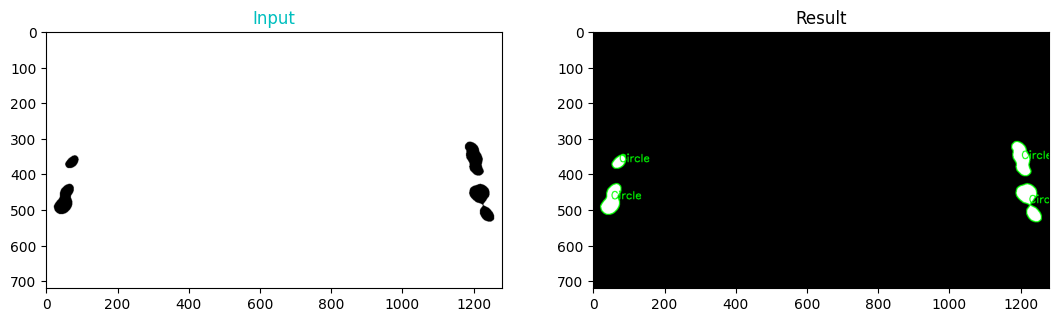

1003.0


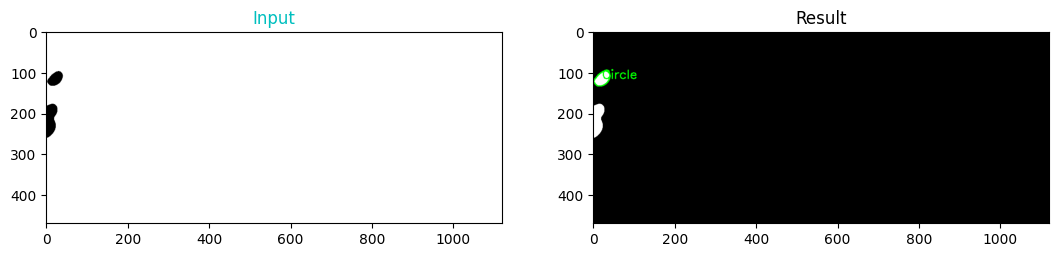

In [ ]:
#Shape Detection
def detectShapes(img_):
    img = img_.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_Otsubin = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_Otsubin.copy(), 1, 2)

    for num,cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        #print(num, approx)
        if len(approx) > 10 and cv2.contourArea(cnt) > 100 :
            print(cv2.contourArea(cnt))
            cv2.putText(img,"Circle",(int(x+w/2),int(y+h/2)),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
            cv2.drawContours(img,[cnt],-1,(0,255,0),2)
            
    plt.figure(figsize=(20,10))
    plt.subplot(131),plt.imshow(cv2.cvtColor(img_Otsubin,cv2.COLOR_BGR2RGB)),plt.title('Input',color='c')
    plt.subplot(132),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Result')
    plt.show()
    return

detectShapes(original)
detectShapes(crop)

In [ ]:
# def circles(filename, p1, p2, minR, maxR):
# # print(filename)
#   img = cv2.imread(filename, 0)
#   img = img[0:1000, 0:1360]
#   l = len(img)
#   w = len(img[1])

#   cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

#   circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 25,
#                               param1 = int(p1) ,param2 = int(p2), minRadius = int(minR), maxRadius = int(maxR))

  
#   for i in circles[0,:]:
#       print(str(i[2] * 1.29 * 2) + "\n")

#   count = 0
#   d = []
#   area = []
#   for i in circles[0,:]:
#       cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#       cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
#       count += 1
#       d += [i[2]*2]
#       area += [i[2]*i[2]*pi*1.286*1.286]

#   f = filename.split("/")[-1]
#   cv2.imwrite(filename[:-4] + "_circle.jpg", cimg)

#   # cv2.imwrite("test3/edge.jpg", edges)
#   print ("Number of Circles is %d")  % count

#   diaM = []
#   for i in d:
#       diaM += [i*1.286]

#   bWidth = range(int(min(diaM)) - 10, int(max(diaM)) + 10, 2)

#   txt = '''
#   Sample name: %s 
#   Average diameter(um): %f     std: %f
#   Drop counts: %d
#   Average coverage per drop(um^2): %f     std: %f
#   ''' % (f, np.mean(diaM), np.std(diaM), count, np.mean(area), np.std(area))

#   fig = plt.figure()
#   fig.suptitle('Histogram of Diameters', fontsize=14, fontweight='bold')
#   ax1 = fig.add_axes((.1,.4,.8,.5))
#   ax1.hist(diaM, bins = bWidth)
#   ax1.set_xlabel('Diameter(um)')
#   ax1.set_ylabel('Frequency')
#   fig.text(.1,.1,txt)
#   plt.savefig(filename[:-4] + '_histogram.jpg')
#   plt.clf()

#   print ("Total area is %d") % (w*l)
#   print ("Total covered area is %d") % (np.sum(area))

#   rt = "Number of Circles is " + str(count) + "\n" + "Coverage percent is " + str(np.divide(np.sum(area), (w*l))) + "\n"
#   return rt

# circles("/content/gdrive/MyDrive/Toyota Innovation Challenge Documents/Training Images/White/White_14.jpg",1,1,1,1)

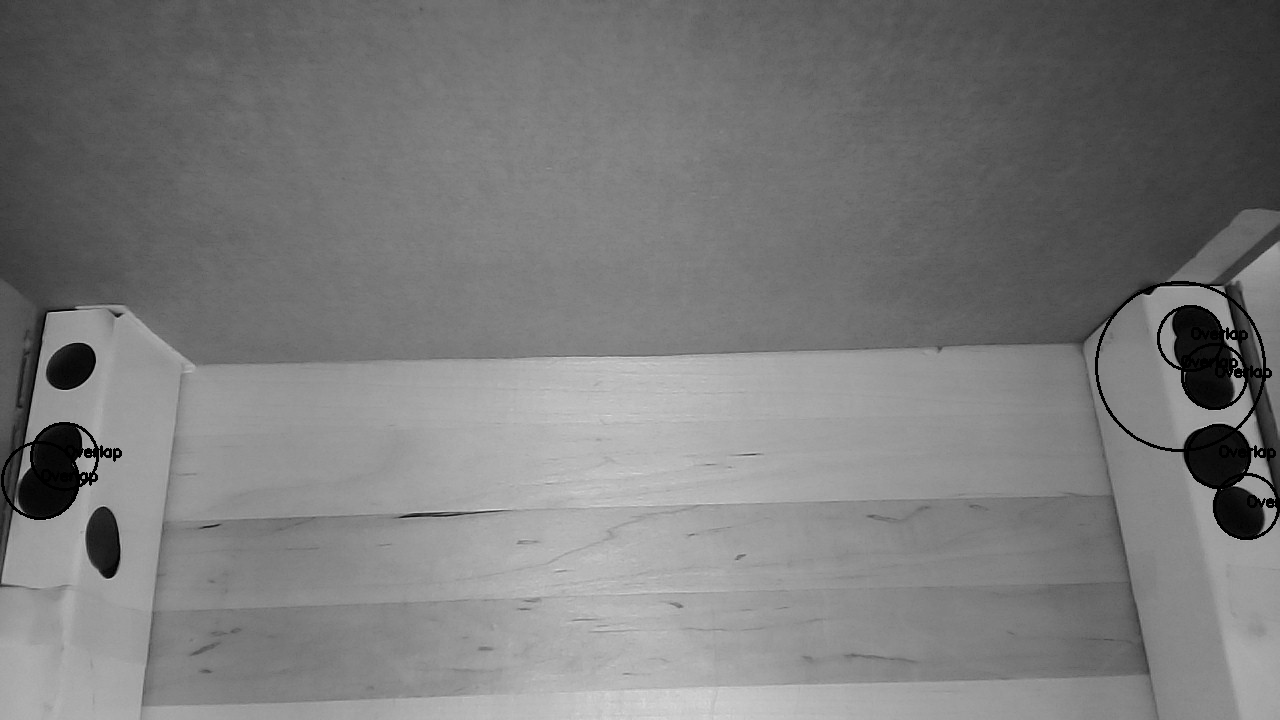

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread(Image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur to reduce noise 
blur = cv2.GaussianBlur(image, (5, 5), 0)

# Perform Hough Circle Transform to detect circles
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1, minDist=30, param1=40, param2=30, minRadius=5, maxRadius=100)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    
    overlapping_circles = []
    
    for (x1, y1, r1) in circles:
        for (x2, y2, r2) in circles:
            if (x1, y1, r1) != (x2, y2, r2):
                # Calculate the distance between circle centers
                center_distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                
                # Check if the circles intersect
                if center_distance < (r1 + r2):
                    overlapping_circles.append((x1, y1, r1))
                    overlapping_circles.append((x2, y2, r2))
    
    # Draw the overlapping circles
    for (x, y, r) in overlapping_circles:
        cv2.circle(image, (x, y), r, (0, 0, 255), 2)
        cv2.putText(image, 'Overlap', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the result
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No circles detected.")

No circles found in the input image.


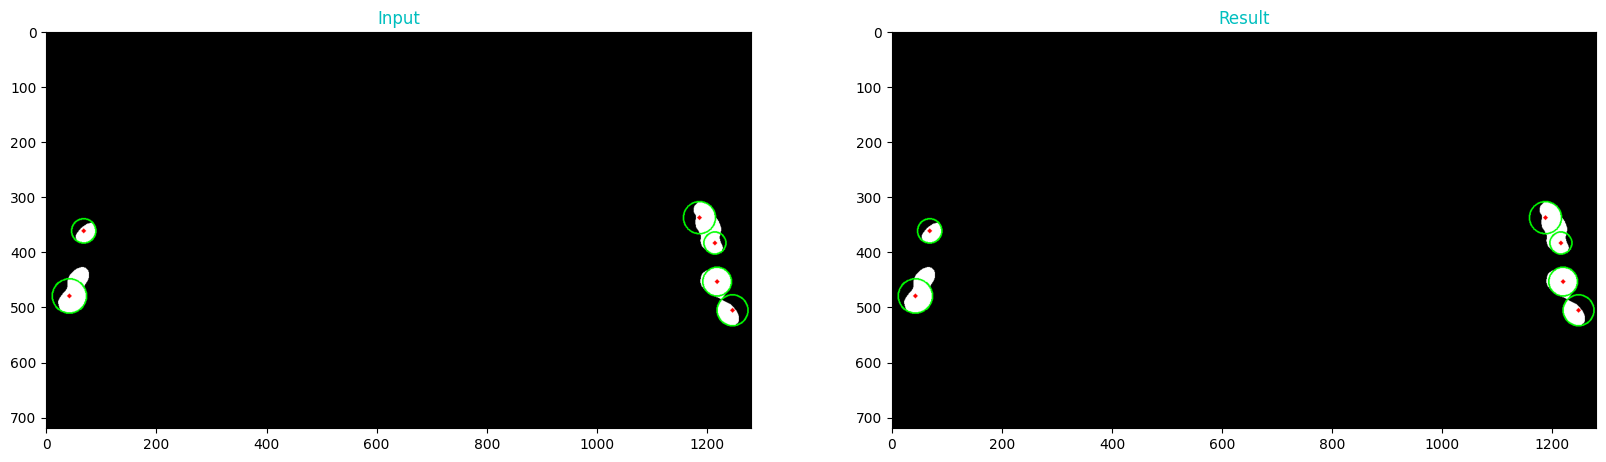

No circles found in the input image.


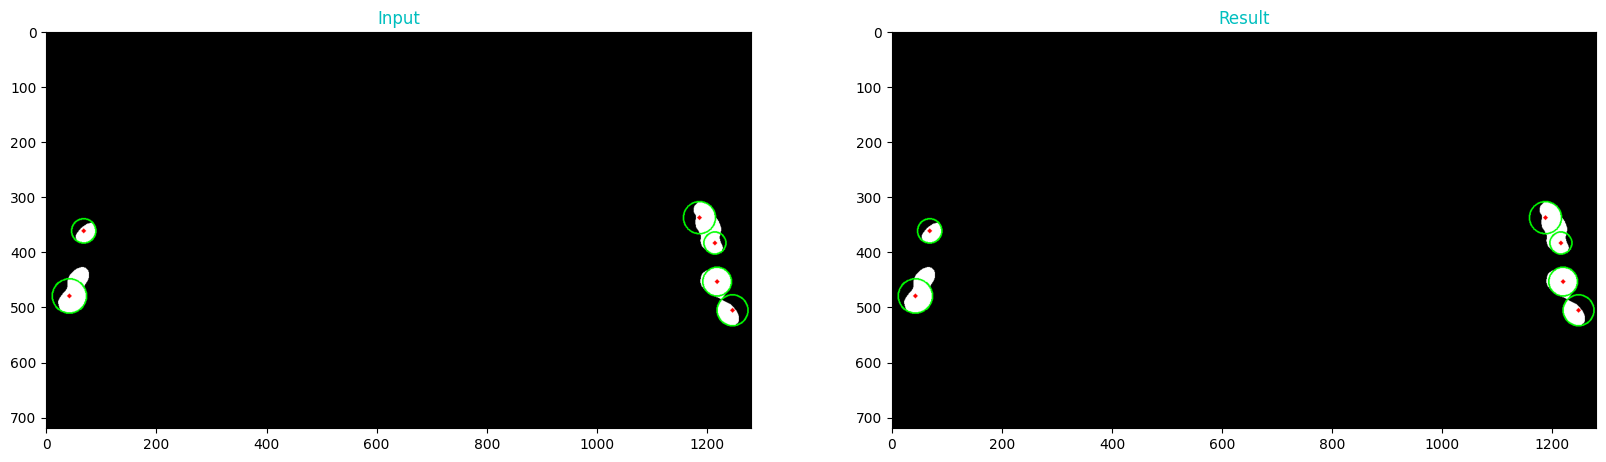

In [ ]:
# Line Detection
def houghLineDetector(img_):
    img = img_.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_edge = cv2.Canny(img,80,200)
    lines = cv2.HoughLinesP(img_edge,5,np.pi/180,20,minLineLength=50,maxLineGap=10)
    if lines is not None:
      for line in lines:
          x1,y1,x2,y2 = line[0]
          cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
      plt.figure(figsize=(20,10))
      plt.subplot(121),plt.imshow(cv2.cvtColor(img_edge,cv2.COLOR_BGR2RGB)),plt.title('Input',color='c')
      plt.subplot(122),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Output',color='c')
      plt.show()
    else:
        print("No lines detected in the image.")
    return

def houghCircleDetector(img_):
    img = img_.copy()
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.medianBlur(img,3)
    img_edge = cv2.Canny(img_blur,100,200)

    circles = cv2.HoughCircles(img_edge,cv2.HOUGH_GRADIENT,1,minDist=0.1,param1=1,param2=700)
    if circles is not None:
      circles = np.uint16(np.around(circles))
      for val in circles[0,:]:
          cv2.circle(img,(val[0],val[1]),val[2],(255,0,0),2)
      plt.figure(figsize=(20,10))
      plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Input',color='c')
      plt.subplot(122),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
      plt.show()
    else:
      print("No circles found in the input image.") 
      plt.figure(figsize=(20,10))
      plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Input',color='c')
      plt.subplot(122),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)),plt.title('Result',color='c')
      plt.show()
      return img

# path_to_img = 'indian_coins.jpg'

#houghLineDetector(path_to_img)
houghCircleDetector(original)
result_img = houghCircleDetector(original)

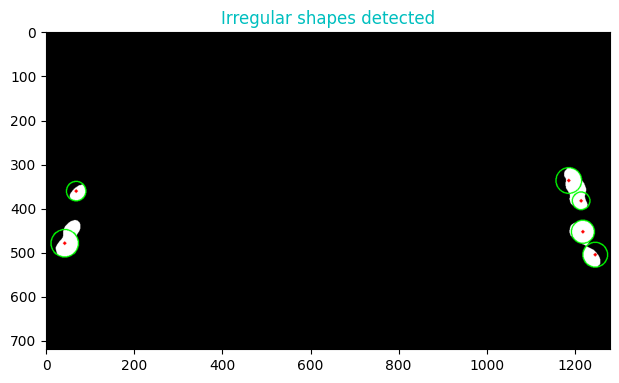

In [ ]:
def detect_irregular_shapes(image_):
    # Read the image
    image = image_
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (15, 9), 0)
    
    # Detect circles using Hough Circle Transform, adjusting param2 for irregular shapes
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=20, minRadius=0, maxRadius=0)
    
    # If circles are detected, draw them on the image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw the circle
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)
    
    # Display the original image and the processed image with detected shapes
    plt.figure(figsize=(16, 6))
    plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Irregular shapes detected', color='c')
    plt.show()

# Call the function with your image path
detect_irregular_shapes(original)
